
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Imports

In [ ]:
#Imports

import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor

# Import our Data

In [ ]:
#Import our data

#URL to our data on my github repo for build week
url = 'https://raw.githubusercontent.com/JeremySpradlin/DS-Unit-2-Build-Week/master/sunspot_data.csv'


df = pd.read_csv(url)
df.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1


# Wrangle Function

In [ ]:
#Create our data wrangling function

def wrangle(df):
  """This function will take in a dataframe of Sunspot activity
  and perform different functions and actions on it to 
  prepare the dataset for training in a predictive model."""

  #Remove spaces from column names and change to lowercase
  df.columns = df.columns.str.lower().str.replace(' ', '_')

  #Replace -1's in target column
  df['number_of_sunspots'].replace(-1, np.NaN, inplace=True)

  #Remove columns
  df = df.drop(['indicator', 'unnamed:_0'], axis=1)

  #Remove observations with missing values or no observations
  df = df.dropna()
  mask = df[(df['observations'] == 0)].index
  df = df.drop(mask)

  #Split our dataset into data and target sets
  y = df['number_of_sunspots']
  X = df.drop('number_of_sunspots', axis=1)

  #Create Training set
  X_train = X[(X['year'] <= 1902)]
  y_train = y[y.index.isin(X_train.index)]

  #Create validation set
  X_val = X[(X['year'] > 1902) & (X['year'] <= 1952)]
  y_val = y[y.index.isin(X_val.index)]

  #Create test set
  X_test = X[(X['year'] > 1952)]
  y_test = y[y.index.isin(X_test.index)]


  #Return the dataframes
  return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = wrangle(df)
X_train.shape, y_train.shape

((27798, 6), (27798,))

# Baseline

In [ ]:
guess = y_train.mean()
errors = guess - y_train
mae = errors.abs().mean()
print('Our naive baseline mae is:', mae)

Our naive baseline mae is: 57.92122350081531


# Create initial Pipeline

In [ ]:
#Create our pipeline

model = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LinearRegression()
)

In [ ]:
#Fit our data to our model

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

# Test initial model

Training Accuracy:  0.9062704166214505
Validation Accuracy:  0.7675162495780349
Testing Accuracy:  0.6303832707461011


# XGB Regressor

In [ ]:
#Create our new pipeline with XGB

xgbmodel = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    XGBRegressor(learning_rate=1.5, n_estimators=200, max_depth=2)
)

In [ ]:
xgbmodel.fit(X_train, y_train)

[18:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=1.5,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=None, n_estimators=200, n_jobs=1,
                              nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=

In [ ]:
#Check our accuracy on our different sets
print('Training Accuracy: ', xgbmodel.score(X_train, y_train))
print('Validation Accuracy: ', xgbmodel.score(X_val, y_val))
print('Testing Accuracy: ', xgbmodel.score(X_test, y_test))

Training Accuracy:  0.999337815394306
Validation Accuracy:  0.88258239364709
Testing Accuracy:  0.5342629550410566


# Permutation Importance

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    xgbmodel, 
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=42
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.


In [ ]:
permuter.fit(X_train, y_train)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('simpleimputer',
                                                 SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose=0)),
                                                ('standardscaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('linearregressio

In [ ]:
#Check our accuracy on our different sets
print('Training Accuracy: ', permuter.score(X_train, y_train))
print('Validation Accuracy: ', permuter.score(X_val, y_val))
print('Testing Accuracy: ', permuter.score(X_test, y_test))

Training Accuracy:  0.9062704166214505
Validation Accuracy:  0.7675162495780349
Testing Accuracy:  0.6303832707461011


In [ ]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_train.columns.tolist()
)

Weight,Feature
885.8704 ± 4.1429,date_in_fraction_of_year
876.2188 ± 6.0254,year
63.4711 ± 0.3869,standard_deviation
3.0239 ± 0.0830,month
0.0258 ± 0.0144,day
0 ± 0.0000,observations


#Partial Dependence Plots

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [ ]:
!pip install pdpbox
from pdpbox.pdp import pdp_isolate, pdp_plot


In [ ]:
feature = 'date_in_fraction_of_year'

isolated = pdp_isolate(
    model=permuter,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


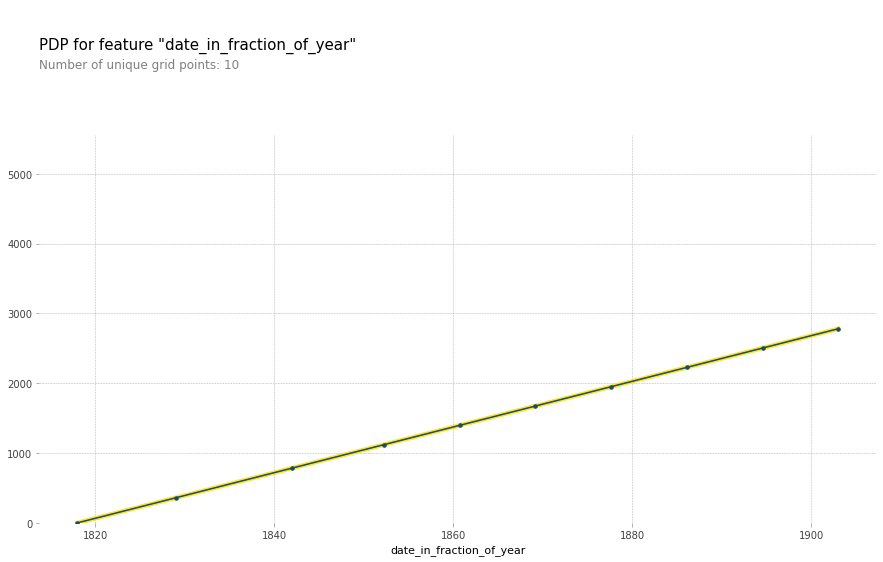

In [ ]:
pdp_plot(isolated, feature_name=feature, plot_lines=True);

In [ ]:
#pdp with 2 features

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['date_in_fraction_of_year', 'year']

interaction = pdp_interact(
    model=permuter,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcdad32e400>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcdafd7ebe0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


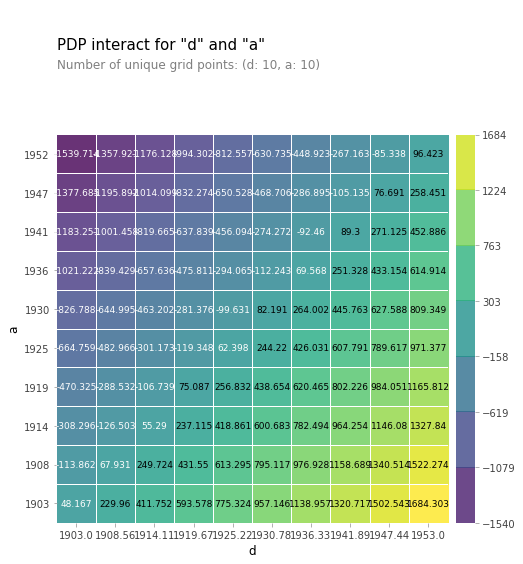

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=feature)

# Shapley Plots

In [ ]:
!pip install shap

In [ ]:
import shap